<a href="https://colab.research.google.com/github/FloatinggOnion/pytorch-zero-to-mastery/blob/main/Classification_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn

RANDOM_STATE = 42

In [ ]:
# creating dataset
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.02, random_state=42)

In [ ]:
# turn into dataframe
import pandas as pd

moons = pd.DataFrame({
      'X1': X[:, 0],
      'X2': X[:, 1],
      'label':y
        },
)

X.shape

(1000, 2)

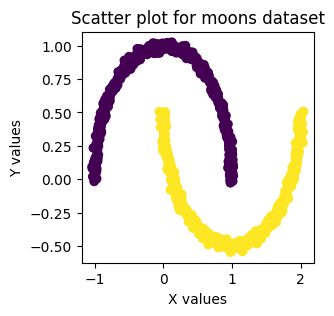

In [ ]:
# visualising in scatter plot
import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3))

plt.scatter(x=X[:,0], y=X[:, 1], c=y, label="moons data")
plt.xlabel('X values')
plt.ylabel('Y values')
plt.title("Scatter plot for moons dataset")

plt.show()

In [ ]:
# turn data into tensors
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()

X.dtype

torch.float32

In [ ]:
# split into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
# building a model with torch.nn
class ClassificationModel(nn.Module):

  def __init__(self):
    super().__init__()

    # 2 layers that can handle input and output values
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

  def forward(self, x):
    # x goes through layer 1, then that goes through layer 2
    return self.layer_2(self.layer_1(x))


model_0 = ClassificationModel().to(device)
model_0

ClassificationModel(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
# set up BCE loss for binary classification
loss_fn = nn.BCEWithLogitsLoss()

# set up stochastic gradient descent for optimization
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

In [ ]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.4906],
        [0.2362],
        [0.5771],
        [0.1914],
        [0.5193]], device='cuda:0', grad_fn=<SliceBackward0>)

In [ ]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.6203],
        [0.5588],
        [0.6404],
        [0.5477],
        [0.6270]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [ ]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [ ]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [ ]:
# training and testing loop

torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


# loop
for epoch in range(epochs):
  model_0.train()

  # forward pass..outputs are logits
  y_logits = model_0(X_train).squeeze() # squeeze to remove '1' dimensions
  y_pred = torch.round(torch.sigmoid(y_logits))


  # calculate loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # optimizer zero grad
  optimizer.zero_grad()

  # loss backwards
  loss.backward()

  optimizer.step()

  # testing
  model_0.eval()
  with torch.inference_mode():
    # forward pass to get logits
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Caculate loss/accuracy
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                            y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.63870, Accuracy: 50.00% | Test loss: 0.64153, Test acc: 50.00%
Epoch: 10 | Loss: 0.62994, Accuracy: 50.00% | Test loss: 0.63351, Test acc: 50.00%
Epoch: 20 | Loss: 0.62129, Accuracy: 51.00% | Test loss: 0.62558, Test acc: 53.00%
Epoch: 30 | Loss: 0.61273, Accuracy: 64.62% | Test loss: 0.61774, Test acc: 62.50%
Epoch: 40 | Loss: 0.60427, Accuracy: 71.38% | Test loss: 0.60997, Test acc: 68.00%
Epoch: 50 | Loss: 0.59589, Accuracy: 75.00% | Test loss: 0.60228, Test acc: 71.50%
Epoch: 60 | Loss: 0.58759, Accuracy: 78.25% | Test loss: 0.59465, Test acc: 74.50%
Epoch: 70 | Loss: 0.57936, Accuracy: 80.75% | Test loss: 0.58709, Test acc: 76.00%
Epoch: 80 | Loss: 0.57122, Accuracy: 82.75% | Test loss: 0.57960, Test acc: 77.50%
Epoch: 90 | Loss: 0.56315, Accuracy: 84.75% | Test loss: 0.57217, Test acc: 79.50%


In [ ]:
# Plot the model predictions
import numpy as np

def plot_decision_boundary(model, X, y):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.figure(figsize=(3, 3))
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


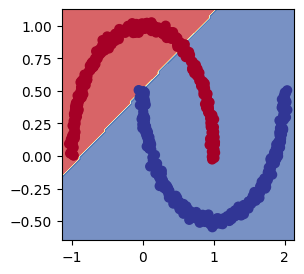

In [ ]:
# decision boundaries for train set
plot_decision_boundary(model_0, X_train, y_train)

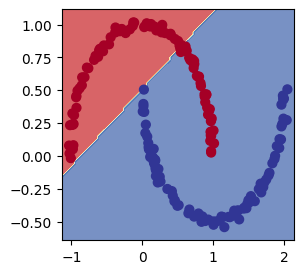

In [ ]:
# decision boundary for test set
plot_decision_boundary(model_0, X_test, y_test)

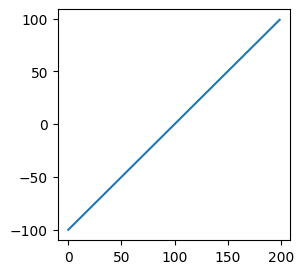

In [ ]:
# creating a straight line tensor
tensor_A = torch.arange(-100, 100, 1)
plt.figure(figsize=(3, 3))
plt.plot(tensor_A)

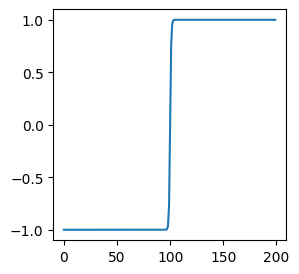

In [ ]:
plt.figure(figsize=(3, 3))
plt.plot(torch.tanh(tensor_A))

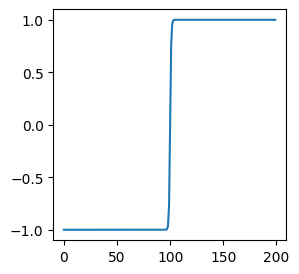

In [ ]:
def tanh(z):
  return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

plt.figure(figsize=(3, 3))
plt.plot(tanh(tensor_A))

# **Multi-Class Classification**

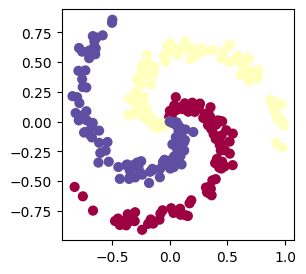

In [ ]:
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.figure(figsize=(3, 3))
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [ ]:
import torch
from torch import nn

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

# create train test splits
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([240, 2]),
 torch.Size([240]),
 torch.Size([60, 2]),
 torch.Size([60]))

In [ ]:
# Let's calculuate the accuracy for when we fit our model
!pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy

## TODO: uncomment the two lines below to send the accuracy function to the device
acc_fn = Accuracy(task="multiclass", num_classes=3).to(device)
acc_fn


MulticlassAccuracy()

In [ ]:
# Prepare device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create model by subclassing nn.Module
class MultiClassModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=2, out_features=10, bias=True)
    self.layer_2 = nn.Linear(in_features=10, out_features=10, bias=True)
    self.layer_3 = nn.Linear(in_features=10, out_features=10, bias=True)
    self.layer_4 = nn.Linear(in_features=10, out_features=10, bias=True)
    self.layer_5 = nn.Linear(in_features=10, out_features=3, bias=True)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_5(self.relu(self.layer_4(self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))))))


# Instantiate model and send it to device
model_0 = MultiClassModel().to(device)
model_0

MultiClassModel(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=10, bias=True)
  (layer_4): Linear(in_features=10, out_features=10, bias=True)
  (layer_5): Linear(in_features=10, out_features=3, bias=True)
  (relu): ReLU()
)

In [ ]:
# Setup data to be device agnostic
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
print(X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype)

# Print out first 10 untrained model outputs (forward pass)
print("Logits:")
## Your code here ##
y_logits = model_0(X_train)[:10]
print(y_logits)

print("Pred probs:")
## Your code here ##
y_pred_probs = torch.softmax(model_0(X_train)[:10], dim=1)
print(y_pred_probs)

print("Pred labels:")
## Your code here ##
print(y_pred_probs.argmax(dim=1))

torch.float32 torch.float32 torch.int64 torch.int64
Logits:
tensor([[-0.1280, -0.2061,  0.2006],
        [-0.1302, -0.2065,  0.1984],
        [-0.1270, -0.2067,  0.2011],
        [-0.1364, -0.2058,  0.1963],
        [-0.1333, -0.2059,  0.1976],
        [-0.1281, -0.2068,  0.2006],
        [-0.1277, -0.2068,  0.2007],
        [-0.1262, -0.2066,  0.2019],
        [-0.1296, -0.2065,  0.1989],
        [-0.1367, -0.2058,  0.1961]], device='cuda:0',
       grad_fn=<SliceBackward0>)
Pred probs:
tensor([[0.3018, 0.2791, 0.4191],
        [0.3016, 0.2795, 0.4189],
        [0.3019, 0.2788, 0.4192],
        [0.3005, 0.2804, 0.4191],
        [0.3010, 0.2799, 0.4191],
        [0.3018, 0.2790, 0.4192],
        [0.3019, 0.2789, 0.4192],
        [0.3020, 0.2787, 0.4193],
        [0.3017, 0.2793, 0.4190],
        [0.3005, 0.2804, 0.4191]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Pred labels:
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')


In [ ]:
# set up loos function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.02)

In [ ]:
y_train.shape

torch.Size([240])

In [ ]:
# Build a training loop for the model
torch.manual_seed(42)

epochs = 1000

# Loop over data
for epoch in range(epochs):
  model_0.train()

  # Forward pass

  ## Training

  # 1. Forward pass
  y_logits = model_0(X_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)


  # 2. Calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = acc_fn(y_pred, y_train)


  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ## Testing
  model_0.eval()
  with torch.inference_mode():

    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    # 2. Caculate loss and acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_pred, y_test)

  # Print out what's happening every 100 epochs
  if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 1.11858, Accuracy: 0.32% | Test loss: 1.09308, Test acc: 0.37%
Epoch: 100 | Loss: 0.35076, Accuracy: 0.80% | Test loss: 0.37422, Test acc: 0.77%
Epoch: 200 | Loss: 0.10031, Accuracy: 0.97% | Test loss: 0.09639, Test acc: 0.97%
Epoch: 300 | Loss: 0.03079, Accuracy: 0.99% | Test loss: 0.00966, Test acc: 1.00%
Epoch: 400 | Loss: 0.02354, Accuracy: 0.99% | Test loss: 0.03517, Test acc: 0.98%
Epoch: 500 | Loss: 0.02036, Accuracy: 0.99% | Test loss: 0.09883, Test acc: 0.98%
Epoch: 600 | Loss: 0.01819, Accuracy: 0.99% | Test loss: 0.12945, Test acc: 0.98%
Epoch: 700 | Loss: 0.01707, Accuracy: 0.99% | Test loss: 0.12406, Test acc: 0.98%
Epoch: 800 | Loss: 0.01642, Accuracy: 0.99% | Test loss: 0.13160, Test acc: 0.98%
Epoch: 900 | Loss: 0.01619, Accuracy: 0.99% | Test loss: 0.13445, Test acc: 0.98%


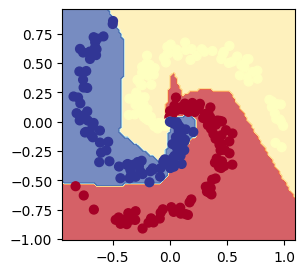

In [ ]:
plot_decision_boundary(model_0, X, y)